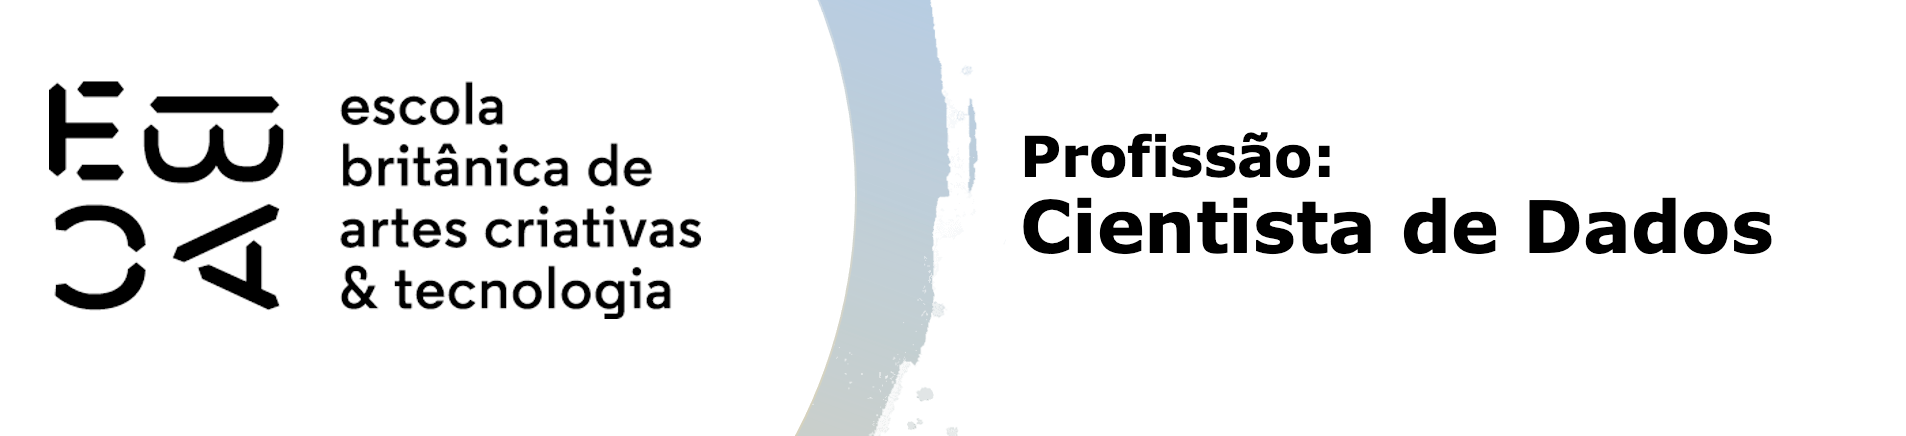

# Regressão III - Tarefa

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

from datetime import timedelta
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
df.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

A coluna "tempo_emprego" possui dados faltantes, que serão substituídos pela média.
    
</div>

## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [4]:
# Substituindo os dados faltantes na coluna tempo_emprego pela média.

df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

In [5]:
df.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          750000 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Podemos ver acima que o Dataframe agora não possui dados faltantes.
    
</div>

### Log da renda

Criando uma coluna com o log da renda que será usada nas bases de treino e teste

In [6]:
df['renda_log'] = np.log(df['renda'])

### Lista de variáveis

Aqui será definida uma lista com os nomes das variáveis explicativas que serão usadas na base de treino e teste.

In [7]:
variaveis = [x for x in list(df.columns) if x not in ['index', 'data_ref']]

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [8]:
# Alterando o tipo da coluna data_ref (index) para datetime

df.index = pd.to_datetime(df.index)

In [9]:
# Encontrando a maior data no dataframe, na coluna data_ref

data_max = df.index.max()
print(data_max)

2016-03-01 00:00:00


In [10]:
# Definindo uma data de corte para os dados de treino e teste.
# Os registros dos últimos 3 meses serão os dados de teste

data_corte = data_max - timedelta(days=3*30)
print(data_corte)

2015-12-02 00:00:00


In [11]:
# recuperando todos os registros dos útlimos 3 meses

df_teste = df.loc[data_corte:].reset_index()[variaveis]

### Base de treino

Cria a base de treino. Todos os registros do Dataframe original, exceto os registros dos últimos três meses.

In [12]:
df_treino = df.loc[:data_corte].reset_index()[variaveis].query('tempo_emprego > 0')

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [13]:
# Funçao para criar um modelo

def model(colunas, dt=df_treino):
    res = smf.ols(f"renda_log ~ {' + '.join(colunas)}", data=dt).fit()
    return res

In [14]:
# modelo usando apenas a variável tempo_emprego

model(['tempo_emprego']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 4.298e+05
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:01:07   Log-Likelihood:            -8.0817e+05
No. Observations:              600000   AIC:                         1.616e+06
Df Residuals:                  599998   BIC:                         1.616e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.2780      0.002   4262.716      0.000       8.274       8.282
tempo_emprego     0.1292      0.000    655.629      0.000       0.129       0.130
==============================================================================
Omnibus:                      798.953   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              717.227
Skew:                          -0.046   Prob(JB):                    1.80e-156
Kurtosis:                       2.857   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

O $R^2-ajustado$ do modelo acima foi de 0.417
    
</div>

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [15]:
# Categorize a variável tempo_emprego em 20 quantis

tempo_emprego_cat, tempo_emprego_quebras = pd.qcut(
    x = df_treino['tempo_emprego'], 
    q = 20, 
    duplicates = 'drop', 
    retbins = True,
    precision = 4
)

In [16]:
# adicionando a classificação em quartis no Dataframe de treino

df_treino['tempo_emprego_cat'] = tempo_emprego_cat

In [17]:
# armazenando como dataframe os dados de cada categoria
df_classificacao = (
    df_treino[['tempo_emprego_cat', 'renda', 'renda_log', 'tempo_emprego']]
    .groupby('tempo_emprego_cat')
    .aggregate({
        'renda': [('media', 'mean')], 
        'renda_log': [('media', 'mean')], 
        'tempo_emprego': [('quantidade', 'count'), ('media', 'mean')]})
    .reset_index() 
)

# renomeando as colunas do Dataframe
df_classificacao.columns = ['_'.join(x) if len(x[1]) > 0 else x[0] for x in df_classificacao.columns]

df_classificacao

,tempo_emprego_cat,renda_media,renda_log_media,tempo_emprego_quantidade,tempo_emprego_media
0,"(0.1177, 0.8164]",6406.615090,8.364965,30234,0.515042
1,"(0.8164, 1.4575]",7316.772629,8.454323,30031,1.125014
2,"(1.4575, 2.0959]",8037.073066,8.569544,29736,1.781261
3,"(2.0959, 2.9123]",8674.879755,8.624148,30013,2.510920
4,"(2.9123, 3.6356]",9762.372783,8.755365,30408,3.301180
5,"(3.6356, 4.2986]",11041.231269,8.855078,29625,3.987156
6,"(4.2986, 4.9342]",11396.170754,8.903273,30109,4.610421
7,"(4.9342, 5.7589]",12888.668890,9.049495,29991,5.367829
8,"(5.7589, 6.6219]",13859.133577,9.139216,30003,6.205546
9,"(6.6219, 7.4712]",15278.462948,9.224298,29926,7.009358


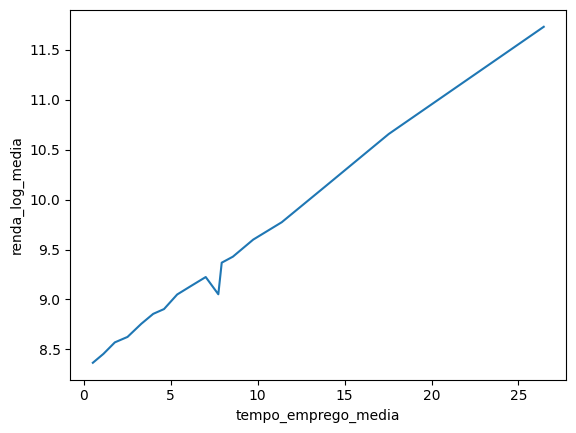

In [18]:
sns.lineplot(data=df_classificacao, x='tempo_emprego_media', y='renda_log_media');

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

Analisando o exercício anterior e o gráfico gerado, parece que a linearização por categorização ou lowess seriam adequadas nesse caso. Talvez as duas poderiam se adequar a varição que pode ser visualizada no gráfico entre 5 e 10.
    
</div>

### Função para o gráfico
 A função abaixo será usada para gerar um gráfico da linearização das variáveis

In [19]:
def grafico(stat, data=df_treino, varx='tempo_emprego', vary='renda_log'):
    pred_ols = stat.get_prediction()
    smm = pred_ols.summary_frame()
    
    iv_l = smm["obs_ci_lower"]
    iv_u = smm["obs_ci_upper"]

    m_l = smm["mean_ci_lower"]
    m_u = smm["mean_ci_upper"]

    ax_var = varx
    ay_var = vary

    fig, ax = plt.subplots(figsize=(13, 6))
    sns.scatterplot(data=data, ax=ax, x=ax_var, y=ay_var, s=10, color="#36adf7", alpha=1)
    sns.lineplot(data=data, errorbar=None, ax=ax, x=ax_var, y=stat.fittedvalues, color='orange')
    sns.lineplot(data=data, errorbar=None, ax=ax, x=ax_var, y=iv_u, color='red', linestyle='dashed')
    sns.lineplot(data=data, errorbar=None, ax=ax, x=ax_var, y=iv_l, color='red', linestyle='dashed')
    sns.lineplot(data=data, errorbar=None, ax=ax, x=ax_var, y=m_u, color='green', linestyle='dotted')
    sns.lineplot(data=data, errorbar=None, ax=ax, x=ax_var, y=m_l, color='green', linestyle='dotted')
    plt.show()

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


- **Categorização**

In [20]:
# adicionando as categorias na base de treino

df_treino.drop(errors='ignore', inplace=True, columns=[
    'renda_media',
    'renda_log_media',
    'tempo_emprego_quantidade',
    'tempo_emprego_media',
    'renda_log_media_x',
    'tempo_emprego_quantidade_x',
    'tempo_emprego_media_x',
    'renda_log_media_y',
    'tempo_emprego_quantidade_y',
    'tempo_emprego_media_y',
])

df_treino = df_treino.merge(df_classificacao, how='left', on='tempo_emprego_cat')

In [21]:
res_cat = model(['tempo_emprego_cat'])
res_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                 2.497e+04
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:01:13   Log-Likelihood:            -8.0975e+05
No. Observations:              600000   AIC:                         1.620e+06
Df Residuals:                  599982   BIC:                         1.620e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           8.3650      0.005   1558.930      0.000       8.354       8.375
tempo_emprego_cat[T.Interval(0.8164, 1.4575, closed='right')]       0.0894      0.008     11.756      0.000       0.074       0.104
tempo_emprego_cat[T.Interval(1.4575, 2.0959, closed='right')]       0.2046      0.008     26.847      0.000       0.190       0.220
tempo_emprego_cat[T.Interval(2.0959, 2.9123, closed='right')]       0.2592      0.008     34.092      0.000       0.244       0.274
tempo_emprego_cat[T.Interval(2.9123, 3.6356, closed='right')]       0.3904      0.008     51.520      0.000       0.376       0.405
tempo_emprego_cat[T.Interval(3.6356, 4.2986, closed='right')]       0.4901      0.008     64.257      0.000       0.475       0.505
tempo_emprego_cat[T.Interval(4.2986, 4.9342, closed='right')]       0.5383      0.008     70.864      0.000       0.523       0.553
tempo_emprego_cat[T.Interval(4.9342, 5.7589, closed='right')]       0.6845      0.008     90.025      0.000       0.670       0.699
tempo_emprego_cat[T.Interval(5.7589, 6.6219, closed='right')]       0.7743      0.008    101.834      0.000       0.759       0.789
tempo_emprego_cat[T.Interval(6.6219, 7.4712, closed='right')]       0.8593      0.008    112.952      0.000       0.844       0.874
tempo_emprego_cat[T.Interval(7.4712, 7.7462, closed='right')]       0.6865      0.006    113.251      0.000       0.675       0.698
tempo_emprego_cat[T.Interval(7.7462, 8.1068, closed='right')]       1.0031      0.010     95.893      0.000       0.983       1.024
tempo_emprego_cat[T.Interval(8.1068, 9.0822, closed='right')]       1.0633      0.008    139.548      0.000       1.048       1.078
tempo_emprego_cat[T.Interval(9.0822, 10.4356, closed='right')]      1.2343      0.008    162.350      0.000       1.219       1.249
tempo_emprego_cat[T.Interval(10.4356, 12.4658, closed='right')]     1.4086      0.008    185.247      0.000       1.394       1.423
tempo_emprego_cat[T.Interval(12.4658, 15.2137, closed='right')]     1.7625      0.008    231.861      0.000       1.748       1.777
tempo_emprego_cat[T.Interval(15.2137, 20.2164, closed='right')]     2.2927      0.008    301.544      0.000       2.278       2.308
tempo_emprego_cat[T.Interval(20.2164, 42.9068, closed='right')]     3.3672      0.008    442.722      0.000       3.352       3.382
==============================================================================
Omnibus:                      556.191   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.930
Skew:                          -0.031   Prob(JB):                    4.56e

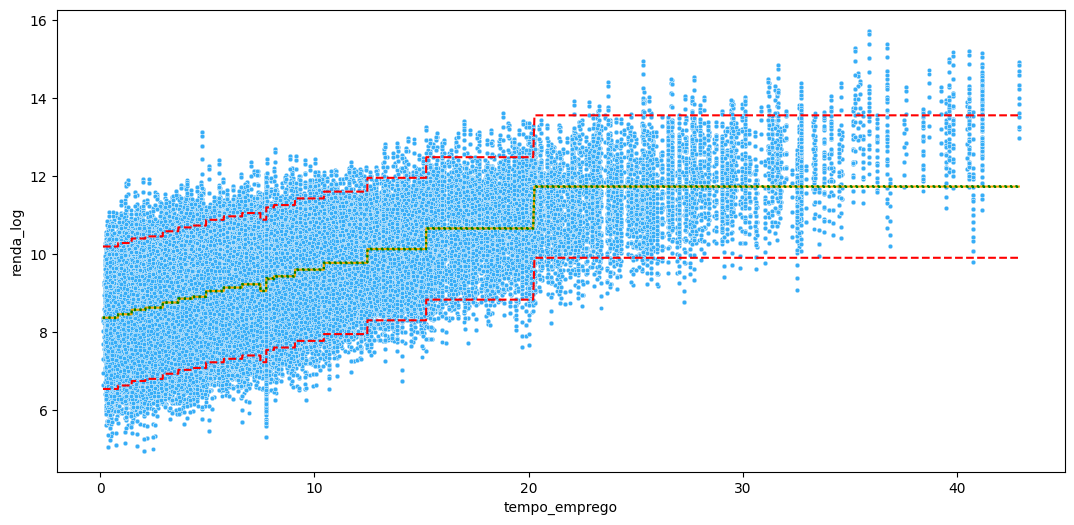

In [22]:
grafico(res_cat)

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

O $R^2-ajustado$ do modelo linearizado por **categorização** foi de 0.414. Praticamente o mesmo resultado do modelo sem nenhuma  linearização.
    
</div>

- **Transformações sobre X**

In [23]:
# transformação do tempo_emprego + tempo_emprego ao quadrado e o seno do tempo
res_log = model(['tempo_emprego + I(tempo_emprego**2) + I(np.sin(tempo_emprego))'], dt=df_treino)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 1.446e+05
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:01:24   Log-Likelihood:            -8.0700e+05
No. Observations:              600000   AIC:                         1.614e+06
Df Residuals:                  599996   BIC:                         1.614e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.3140      0.003   2967.691      0.000       8.309       8.320
tempo_emprego                0.1261      0.001    247.056      0.000       0.125       0.127
I(tempo_emprego ** 2)     8.242e-05   1.76e-05      4.673      0.000    4.78e-05       0.000
I(np.sin(tempo_emprego))    -0.0797      0.002    -48.155      0.000      -0.083      -0.076
==============================================================================
Omnibus:                      830.978   Durbin-Watson:                   1.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              741.905
Skew:                          -0.045   Prob(JB):                    7.90e-162
Kurtosis:                       2.853   Cond. No.                         482.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

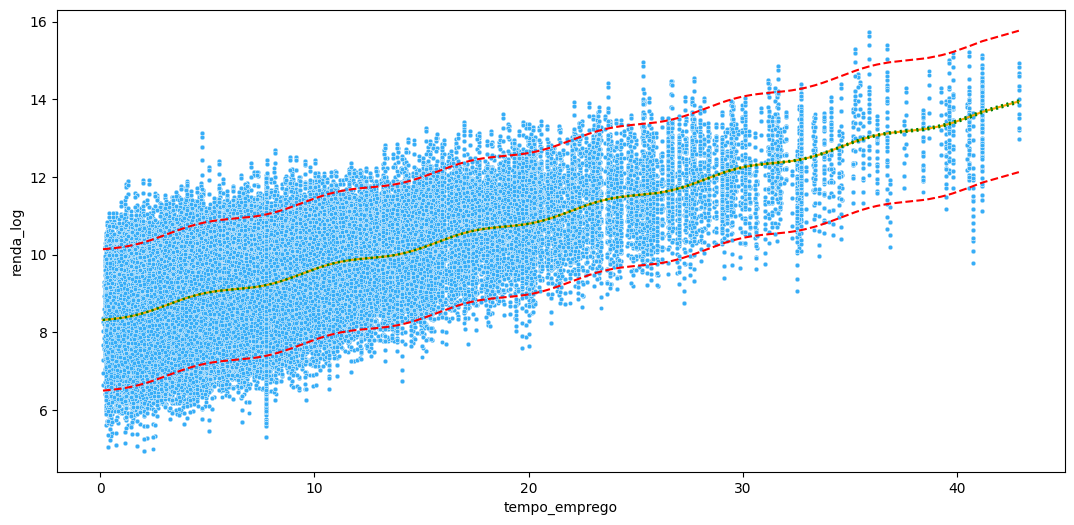

In [24]:
grafico(res_log)

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

O $R^2-ajustado$ do modelo linearizado por **transformações sobre X** foi de 0.42.
    
</div>

- **Regressão segmentada**

In [25]:
# Aqui foi selecionado 35 porque, analisando o gráfico, a renda tende a crescer até esse valor, quando então estabiliza
C1=35

df_treino['X1_1'] = (df_treino.tempo_emprego<=C1)*df_treino.tempo_emprego + (df_treino.tempo_emprego>C1)*C1
df_treino['X1_2'] = (df_treino.tempo_emprego<=C1)*0 + (df_treino.tempo_emprego>C1)*(df_treino.tempo_emprego-C1)

res_seg = model(['X1_1', 'X1_2'], dt=df_treino)
res_seg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                 2.151e+05
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:01:34   Log-Likelihood:            -8.0808e+05
No. Observations:              600000   AIC:                         1.616e+06
Df Residuals:                  599997   BIC:                         1.616e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2728      0.002   4177.876      0.000       8.269       8.277
X1_1           0.1299      0.000    632.093      0.000       0.130       0.130
X1_2           0.0698      0.004     15.714      0.000       0.061       0.079
==============================================================================
Omnibus:                      813.022   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.044
Skew:                          -0.046   Prob(JB):                    8.08e-159
Kurtosis:                       2.856   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

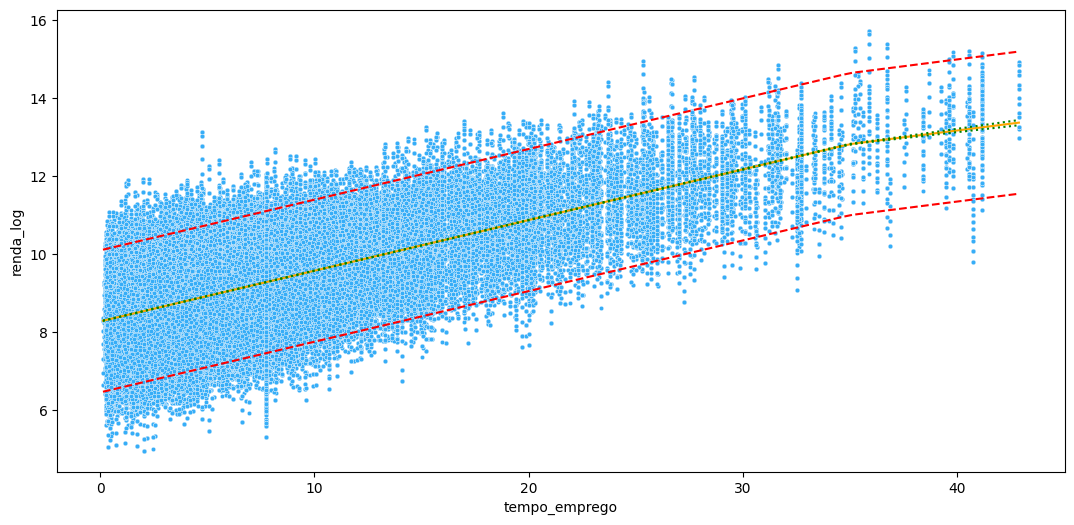

In [26]:
grafico(res_seg)

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

O $R^2-ajustado$ do modelo linearizado por **regressão segmentada** foi de 0.418.
    
</div>

- **Lowess**

In [27]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_treino['renda_log'], df_treino['tempo_emprego'], frac=2/3)

# Valores de Y suavizados
lowess_y = lowess[:, 1]

# Valores de X
lowess_x = lowess[:, 0]

In [28]:
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_treino['X1_lowess'] = f(df_treino['tempo_emprego'])

In [29]:
res_low = model(['X1_lowess'], dt=df_treino)
res_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 4.354e+05
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:02:43   Log-Likelihood:            -8.0656e+05
No. Observations:              600000   AIC:                         1.613e+06
Df Residuals:                  599998   BIC:                         1.613e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0169      0.014      1.197      0.231      -0.011       0.044
X1_lowess      0.9971      0.002    659.838      0.000       0.994       1.000
==============================================================================
Omnibus:                      868.551   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              774.847
Skew:                          -0.047   Prob(JB):                    5.55e-169
Kurtosis:                       2.851   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

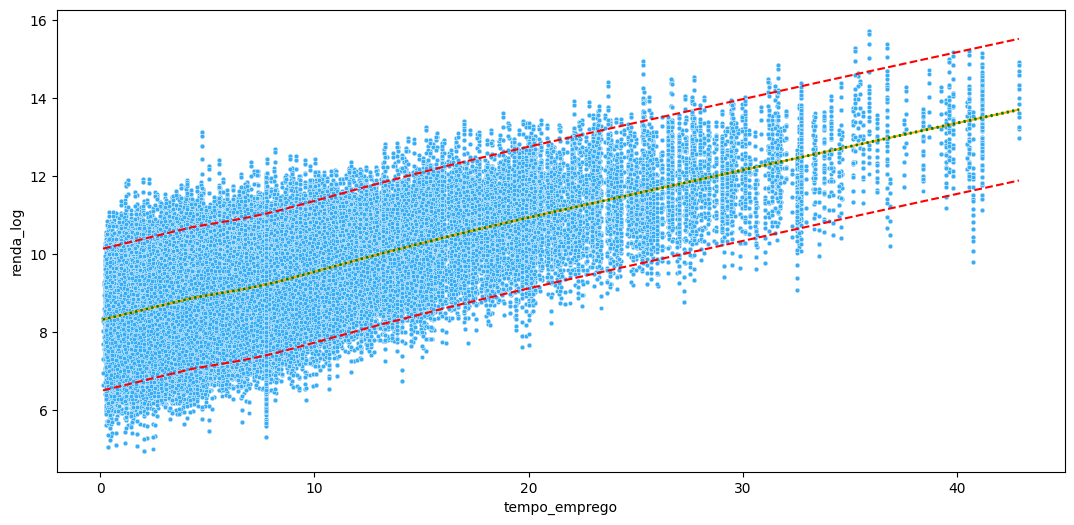

In [30]:
grafico(res_low)

<div style="background-color: #eafce3; padding: 8px 5px 8px 5px;">

O $R^2-ajustado$ do modelo linearizado por **lowess** foi de 0.421.
    
</div>

***
Considerando que todos os modelos foram treinados com apenas uma variável e que não foi realizada nenhuma análise nos dados do Dataframe, entre todas as linearizações, as que apresentaram melhor resultado foi a transformações sobre X e lowess.
***

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

- **Avaliando a base de teste pela transformação sobre X**

In [31]:
y_pred = res_log.predict(df_teste)

In [32]:
r2 = r2_score(df_teste['renda_log'], y_pred)
print(f'O R2 do modelo foi: {r2}')

O R2 do modelo foi: 0.4200124378961772


- **Avaliando a base de teste pelo lowess**

In [33]:
y_pred = res_low.predict(df_teste)

In [35]:
r2 = r2_score(df_teste['renda_log'], y_pred)
print(f'O R2 do modelo foi: {r2}')

O R2 do modelo foi: 0.4216324918352561
